In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dl-hw2-data/train_hwk02_new.csv
/kaggle/input/dl-hw2-data/DICOM/A740156/00010021
/kaggle/input/dl-hw2-data/DICOM/A481686/00010030
/kaggle/input/dl-hw2-data/DICOM/A558231/00010036
/kaggle/input/dl-hw2-data/DICOM/A608573/00010019
/kaggle/input/dl-hw2-data/DICOM/A514552/00010020
/kaggle/input/dl-hw2-data/DICOM/A672570/00010023
/kaggle/input/dl-hw2-data/DICOM/A340115/00010036
/kaggle/input/dl-hw2-data/DICOM/A325875/00010019
/kaggle/input/dl-hw2-data/DICOM/A596084/00010021
/kaggle/input/dl-hw2-data/DICOM/A520919/00010031
/kaggle/input/dl-hw2-data/DICOM/A718487/00010023
/kaggle/input/dl-hw2-data/DICOM/A681216/00010023
/kaggle/input/dl-hw2-data/DICOM/A159139/00010031
/kaggle/input/dl-hw2-data/DICOM/A741758/00010017
/kaggle/input/dl-hw2-data/DICOM/A15422/00010024
/kaggle/input/dl-hw2-data/DICOM/A29870/00010019
/kaggle/input/dl-hw2-data/DICOM/X388459/00010022
/kaggle/input/dl-hw2-data/DICOM/A521149/00010022
/kaggle/input/dl-hw2-data/DICOM/A658847/00010022
/kaggle/input/dl-hw2-data

In [2]:
!pip install torchsummary

In [3]:
import pydicom
import pandas as pd
import numpy as np
import os
import random
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
import torchvision.transforms as transforms
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler

import gc
import cv2

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [4]:
new_data = pd.read_csv("/kaggle/input/dl-hw2-data/train_hwk02_new.csv")

In [5]:
new_data_label_dist = new_data.iloc[:,5].value_counts().sort_index()
new_data_label_dist = pd.DataFrame(
    {
        "label" : new_data_label_dist.index.astype(str),
        "number of samples" : new_data_label_dist.values
    }
)

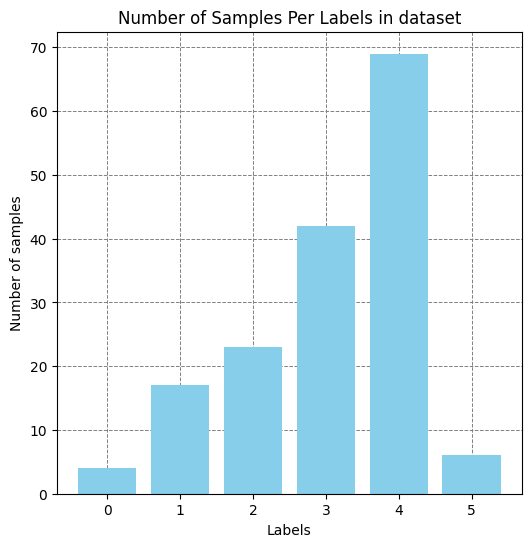

In [6]:
from matplotlib.ticker import MaxNLocator

labels, counts = new_data_label_dist["label"], new_data_label_dist["number of samples"]

plt.figure(figsize = (6, 6))

# 設定 zorder 為 2，讓長條圖在網格線上面顯示
plt.bar(labels, counts, color = 'skyblue', zorder = 2)

plt.xlabel('Labels')
plt.ylabel("Number of samples")
plt.title("Number of Samples Per Labels in dataset")

# 設定 x 軸為整數
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which = 'both', axis = 'both', linestyle = '--', color='gray', linewidth = 0.7, zorder = 1)


# 顯示圖表
plt.show()


In [7]:
n = new_data.shape[0]
train_ids, valid_ids = train_test_split(
    np.linspace(0, n-1, n).astype(int),
    test_size = 0.2,
    random_state = 42,
    stratify = new_data.Stage_New
)

In [8]:
print(f"There are {len(train_ids)} samples in training set.")
print(f"There are {len(valid_ids)} samples in validation set.")

There are 128 samples in training set.
There are 33 samples in validation set.


In [9]:
train_data = new_data.iloc[train_ids]
print(train_data["Stage_New"].value_counts().sort_index())

Stage_New
0     3
1    14
2    18
3    33
4    55
5     5
Name: count, dtype: int64


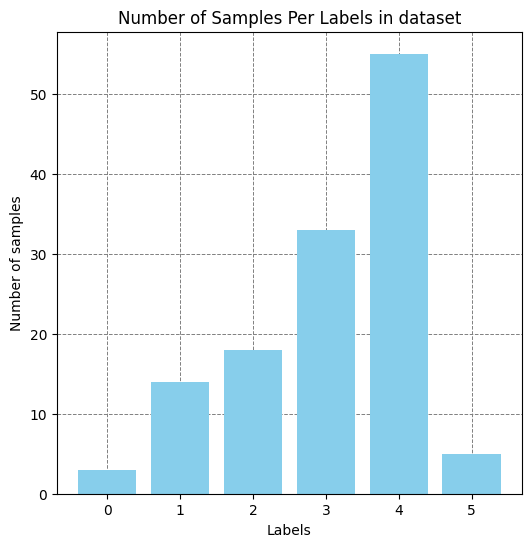

In [10]:
train_label_dict = train_data["Stage_New"].value_counts().sort_index()
train_label_dict = pd.DataFrame(
    {
        "label" : train_label_dict.index.astype(str),
        "number of samples" : train_label_dict.values
    }
)

labels, counts = train_label_dict["label"], train_label_dict["number of samples"]

plt.figure(figsize = (6, 6))

# 設定 zorder 為 2，讓長條圖在網格線上面顯示
plt.bar(labels, counts, color = 'skyblue', zorder = 2)

plt.xlabel('Labels')
plt.ylabel("Number of samples")
plt.title("Number of Samples Per Labels in dataset")

# 設定 x 軸為整數
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which = 'both', axis = 'both', linestyle = '--', color='gray', linewidth = 0.7, zorder = 1)


# 顯示圖表
plt.show()

In [11]:
from imblearn.over_sampling import RandomOverSampler

In [12]:
oversampler = RandomOverSampler(random_state = 42)
train_data_ros_X, train_data_ros_y = oversampler.fit_resample(train_data.iloc[:, 1:5], train_data.iloc[:, 5])
train_data_ros = pd.concat([train_data_ros_X, train_data_ros_y], axis = 1)

In [13]:
train_data_ros["Stage_New"].value_counts().sort_index()

Stage_New
0    55
1    55
2    55
3    55
4    55
5    55
Name: count, dtype: int64

In [14]:
# 計算 train_data["Stage_New"] 中每個類別的樣本數量，並且依照類別索引順序排列，最後存為一個列表 class_num
class_num = [item for item in train_data["Stage_New"].value_counts().sort_index()]
print("class_num: ", class_num)

# 使用所有訓練樣本數量 len(train_ids) 除以 class_num 中每個類別的樣本數量，以此來計算每個類別的權重。
# 樣本數量少的類別會得到比較高的權重，而樣本數量多的類別會得到較低的權重。
class_weight = len(train_ids) / torch.FloatTensor(class_num)
print("\nclass_weight: ", class_weight)

# 將 class_weight 正規化，讓所有權重的總和為 1
class_weight = class_weight / class_weight.sum()
print("\nclass_weight: ", class_weight)

class_num:  [3, 14, 18, 33, 55, 5]

class_weight:  tensor([42.6667,  9.1429,  7.1111,  3.8788,  2.3273, 25.6000])

class_weight:  tensor([0.4703, 0.1008, 0.0784, 0.0428, 0.0257, 0.2822])


In [35]:
# TODO: 調整適當的超參數
class config:
    
    root = "/kaggle/input/dl-hw2-data"
    num_classes = 6
    valid_prob = 0.2
    batch_size = 4
    epochs = 50
    lr = 0.00001
    weight_decay = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


In [16]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 

In [17]:
# Transformation
class Normalization(object):  # 自定義的類別
    def __call__(self, image):  # 定義有 image 之後要進行的資料處理
        new_image = (image - image.min()) / (image.max() - image.min())
        return new_image

def build_transform(is_train):
    t = []
    if is_train:       
        t.append(v2.CenterCrop(size=(50, 50)))
        t.append(v2.RandomRotation(degrees=5, interpolation=2))  # 添加小幅度隨機旋轉，範圍為 -10 到 10 度
        t.append(Normalization())        
        return v2.Compose(t)

    # 驗證集的變換
    t.append(v2.CenterCrop(size=(50, 50)))
    t.append(Normalization())
    return v2.Compose(t)


In [20]:
import pydicom
import torch
import numpy as np

class ParkinsonsDataset(torch.utils.data.Dataset):

    def __init__(self, df, mode=None, transforms=None):
        self.df = df
        self.mode = mode
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, x):
    
        age = torch.tensor(self.df.iloc[x, 1], dtype=torch.float32)  
        gender = torch.tensor(self.df.iloc[x, 2], dtype=torch.float32)  
        index = int(self.df.iloc[x, 4])  

        
        image_path = config.root + self.df.iloc[x, 3]  
        image = pydicom.dcmread(image_path).pixel_array.astype(np.float32)  
        image = torch.tensor(image)

        
        index = max(1, min(index, image.shape[0] - 2))  # 保證 index 在合法範圍內
        image = image[index - 1:index + 2, :, :]  # 提取三張切片，形狀為 (3, H, W)

       
        if self.transforms:
            image = self.transforms(image)

       
        if self.mode in ["train", "valid"]:
            label = torch.tensor(self.df.iloc[x, 5], dtype=torch.long)  # 標籤類型應為 long
            return image, age, gender, label

        elif self.mode == "test":
            return image, age, gender

        else:
            raise ValueError("Mode must be 'train', 'valid', or 'test'.")


In [21]:
def evaluator(preds, gts):
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average = "macro")
    misclassification_rate = 1 - acc
    
    return acc, f1, misclassification_rate

In [30]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train() 
    train_loss = 0.0
    predictions, ground_truths = [], []

    for images, ages, genders, labels in train_loader:
        images = images.to(device=device, dtype=torch.float)
        ages = ages.to(device=device, dtype=torch.float)
        genders = genders.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)

        optimizer.zero_grad()
        logits = model(images, ages, genders)

        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()  # 新增：更新學習率

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)

        predictions.append(preds)
        ground_truths.append(labels)

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1, train_misclass = evaluator(predictions, ground_truths)

    return train_loss, 100 * train_acc, 100 * train_f1, 100 * train_misclass


In [23]:
def validation(model, valid_loader, criterion, device):
    model.eval()  # 設置模型為評估模式
    valid_loss = 0.0
    predictions, ground_truths = [], []
    
    with torch.no_grad():  # 禁用梯度計算
        for images, ages, genders, labels in valid_loader:
            # 將數據移動到設備上（CPU 或 GPU），並設置類型
            images = images.to(device=device, dtype=torch.float)
            ages = ages.to(device=device, dtype=torch.float)
            genders = genders.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            # 前向傳播，通過模型獲取 logits
            logits = model(images, ages, genders)
            
            # 計算損失
            loss = criterion(logits, labels)

            # 累加損失值
            valid_loss += loss.item()
            
            # 獲取預測值，通過 argmax 取得每個樣本的預測類別
            preds = torch.argmax(logits, dim=1)

            # 收集預測結果和真實標籤
            predictions.append(preds)
            ground_truths.append(labels)

        # 計算平均損失
        valid_loss /= len(valid_loader)

        # 拼接所有批次的預測和標籤
        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)

        # 使用 evaluator 函數來計算準確率、F1 分數、錯誤分類率
        valid_acc, valid_f1, valid_misclass = evaluator(predictions, ground_truths)
        
    # 返回驗證損失和評估指標
    return valid_loss, 100 * valid_acc, 100 * valid_f1, 100 * valid_misclass


In [25]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet50plus(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), features_grad=False):
        super().__init__()
        
        # 加載預訓練的 ResNet50
        resnet50 = models.resnet50(weights='IMAGENET1K_V1', progress=True)
        
        # 修改 ResNet50 的全局池化層為自適應平均池化，將輸出固定為 1x1
        resnet50.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # 移除 ResNet50 的分類層
        resnet50.fc = nn.Identity()
        
        # 固定特徵層參數
        for param in resnet50.parameters():
            param.requires_grad = features_grad
        
        # 保存 ResNet50 作為特徵提取器
        self.backend = resnet50
        
        # 增加分類層，輸入為 2048（ResNet 特徵）+ 2（年齡和性別）
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 2, num_classes)  # 2048: resnet50 特徵層結果, 2: age & gender
        )

    def forward(self, x, age, gender):
        output = self.backend(x)  # 提取 ResNet50 特徵，output size = (batch_size, 2048)
        outputs = torch.cat([output, age.view(-1, 1), gender.view(-1, 1)], dim=1)  # 拼接特徵和額外信息
        outputs = self.classifier(outputs)  # 經過分類層
        return outputs

In [26]:
model = ResNet50plus(num_classes = 6)
total_params = sum(p.numel() for p in model.parameters())
print("總參數量:", total_params)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s] 


總參數量: 23520338


Initializing dataset...
Number of classes before random oversampling: [3, 14, 18, 33, 55, 5]
Number of classes after random oversampling: [55, 55, 55, 55, 55, 55]
Initializing model...
Epoch[1/50], Train Loss: 2.1235, Train Accuracy: 15.15%, Train F1: 7.39% | Valid Loss: 2.4796, Valid Accuracy: 3.03%, Valid F1: 1.19% | LR: 0.000001
Epoch[2/50], Train Loss: 2.0552, Train Accuracy: 16.36%, Train F1: 8.35% | Valid Loss: 2.5463, Valid Accuracy: 3.03%, Valid F1: 1.23% | LR: 0.000001
Epoch[3/50], Train Loss: 2.0319, Train Accuracy: 19.70%, Train F1: 11.63% | Valid Loss: 2.3706, Valid Accuracy: 3.03%, Valid F1: 1.52% | LR: 0.000001
Epoch[4/50], Train Loss: 1.9569, Train Accuracy: 26.06%, Train F1: 18.65% | Valid Loss: 2.4702, Valid Accuracy: 3.03%, Valid F1: 1.52% | LR: 0.000002
Epoch[5/50], Train Loss: 1.8899, Train Accuracy: 27.58%, Train F1: 18.47% | Valid Loss: 2.3110, Valid Accuracy: 3.03%, Valid F1: 1.52% | LR: 0.000003
Epoch[6/50], Train Loss: 1.7664, Train Accuracy: 33.64%, Train F1: 

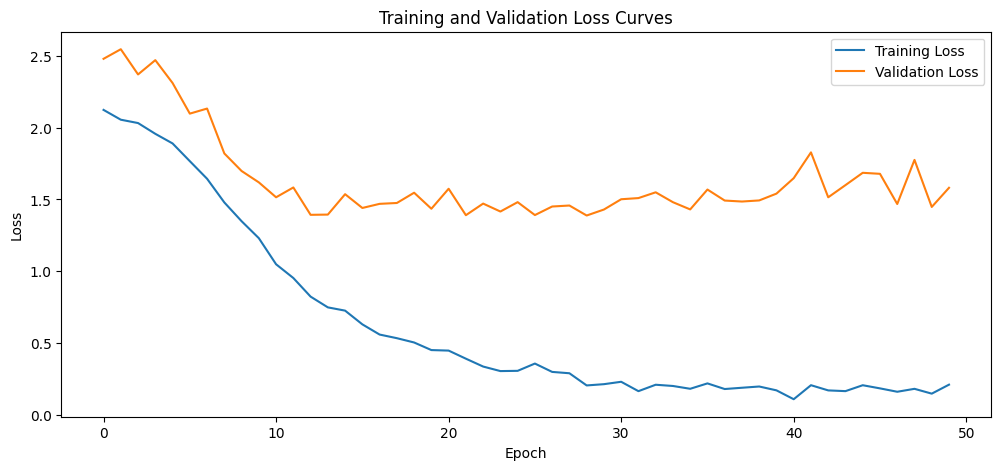

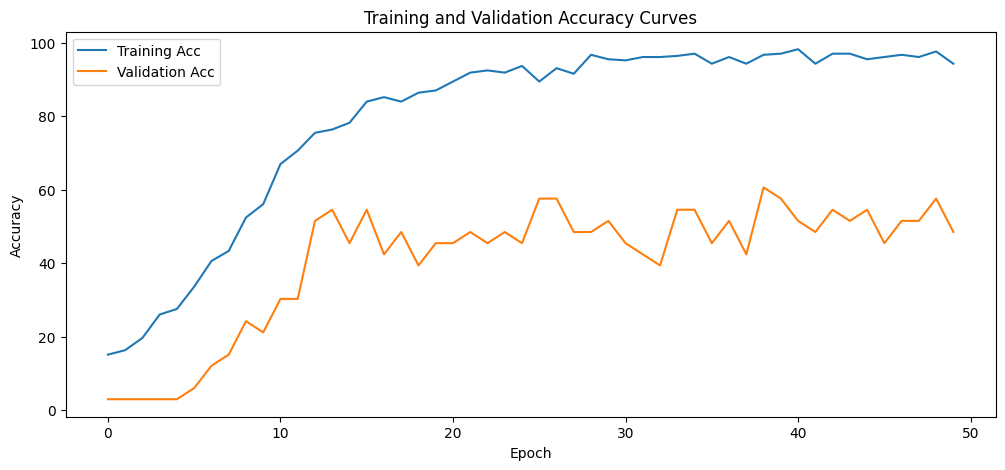

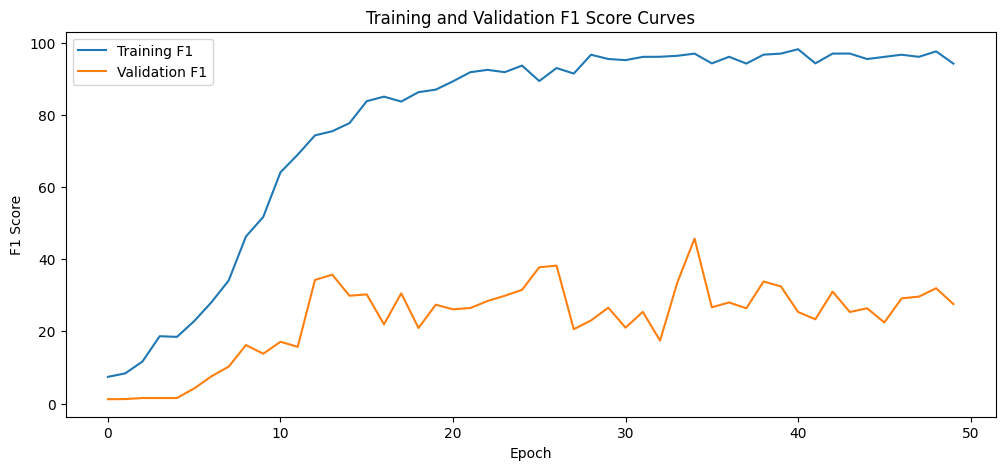

**********  Final Validation  **********
Valid Loss: 1.3877, Valid Accuracy: 48.48%, Valid F1: 23.03%


In [36]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def main():
    # 設置隨機種子以保證結果的可重現性
    seed_everything(config.seed)

    # 加載數據集
    print("Initializing dataset...")
    new_data = pd.read_csv(os.path.join(config.root, 'train_hwk02_new.csv'))

    # 分割訓練和驗證數據集
    n = new_data.shape[0]    
    train_ids, valid_ids = train_test_split(
        np.linspace(0, n - 1, n).astype("int"),
        test_size=0.2,
        random_state=config.seed,
        stratify=new_data.Stage_New
    )
    train_data = new_data.iloc[train_ids]
    valid_data = new_data.iloc[valid_ids]
    
    num_class = [num for num in train_data.iloc[:, 5].value_counts().sort_index()]
    print(f"Number of classes before random oversampling: {num_class}")
    
    # 進行 random oversampling
    oversampler = RandomOverSampler(random_state=42)
    train_data_ros_X, train_data_ros_y = oversampler.fit_resample(train_data.iloc[:, 0:5], train_data.iloc[:, 5])
    train_data_ros = pd.concat([train_data_ros_X, train_data_ros_y], axis=1)
    num_class = [num for num in train_data_ros.iloc[:, 5].value_counts().sort_index()]
    print(f"Number of classes after random oversampling: {num_class}")
    
    # 創建訓練和驗證數據集及數據加載器
    train_dataset = ParkinsonsDataset(train_data_ros, mode="train", transforms=build_transform(True))
    valid_dataset = ParkinsonsDataset(valid_data, mode="valid", transforms=build_transform(False))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    # 模型設置
    print("Initializing model...")
    model = ResNet50plus(num_classes=config.num_classes, features_grad=True)
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    parameters = [p for p in model.parameters() if p.requires_grad] 

# 優化器和學習率調度器設置
    optimizer = torch.optim.AdamW(parameters, lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=config.lr,
        epochs=config.epochs,
        steps_per_epoch=len(train_loader),
        anneal_strategy='cos'
    )

    
    # 記錄器
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }

    # 訓練迭代
    for epoch in range(config.epochs):
        # 單個 epoch 訓練
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(
            model, train_loader, optimizer, scheduler, criterion, config.device
        )
        
        # 單個 epoch 驗證
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(
            model, valid_loader, criterion, config.device
        )

        # 記錄損失和評估指標
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        # 打印結果
        print(f'Epoch[{epoch+1}/{config.epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # 保存最佳模型
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")

    # 加載最佳模型進行最終驗證
    best_ckpt = torch.load("checkpoint.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])

    # 可視化損失和評估指標曲線
    epochs_range = range(config.epochs)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs_range, history["train"]["loss"], label='Training Loss')
    plt.plot(epochs_range, history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs_range, history["train"]["acc"], label='Training Acc')
    plt.plot(epochs_range, history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs_range, history["train"]["f1"], label='Training F1')
    plt.plot(epochs_range, history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

    # 最終驗證
    valid_loss, valid_acc, valid_f1, valid_misclass = validation(
        model, valid_loader, criterion, config.device
    )
    print("*" * 10, " Final Validation ", "*" * 10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")

if __name__ == "__main__":
    main()


Initializing dataset...

Class weights:  tensor([0.4703, 0.1008, 0.0784, 0.0428, 0.0257, 0.2822])
Initializing model...
Epoch[1/50], Train Loss: 2.3390, Train Accuracy: 3.91%, Train F1: 5.65% | Valid Loss: 2.3603, Valid Accuracy: 3.03%, Valid F1: 1.15% | LR: 0.000001
Epoch[2/50], Train Loss: 2.3242, Train Accuracy: 2.34%, Train F1: 3.47% | Valid Loss: 2.3864, Valid Accuracy: 6.06%, Valid F1: 6.04% | LR: 0.000001
Epoch[3/50], Train Loss: 2.2544, Train Accuracy: 3.12%, Train F1: 4.47% | Valid Loss: 2.3976, Valid Accuracy: 3.03%, Valid F1: 1.28% | LR: 0.000001
Epoch[4/50], Train Loss: 2.2565, Train Accuracy: 4.69%, Train F1: 6.58% | Valid Loss: 2.3242, Valid Accuracy: 3.03%, Valid F1: 1.23% | LR: 0.000002
Epoch[5/50], Train Loss: 2.2416, Train Accuracy: 4.69%, Train F1: 4.92% | Valid Loss: 2.3035, Valid Accuracy: 0.00%, Valid F1: 0.00% | LR: 0.000003
Epoch[6/50], Train Loss: 2.1211, Train Accuracy: 7.03%, Train F1: 8.33% | Valid Loss: 2.2115, Valid Accuracy: 3.03%, Valid F1: 1.33% | LR: 0

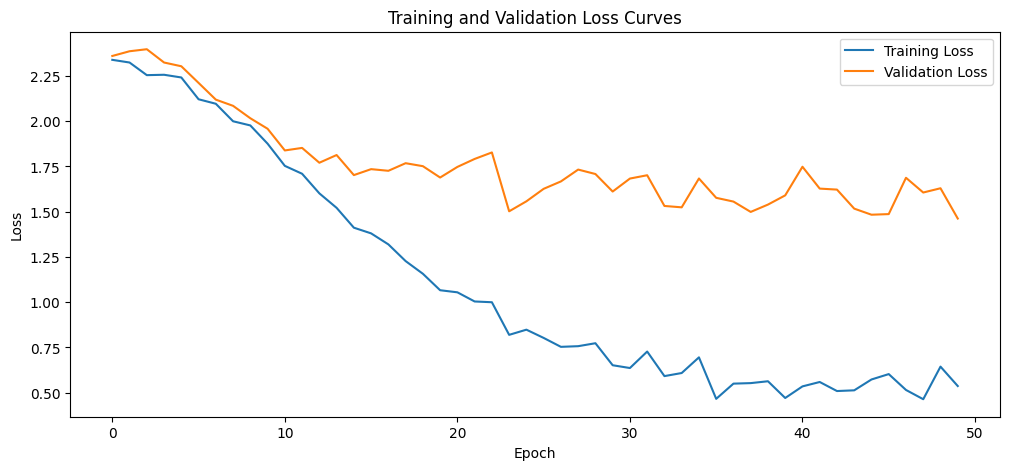

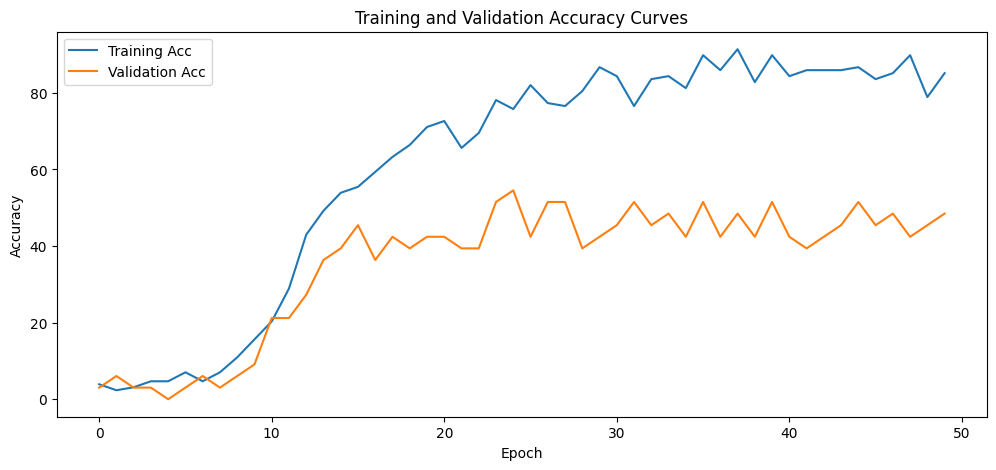

**********  Final Validation  **********
Valid Loss: 1.4622, Valid Accuracy: 48.48%, Valid F1: 25.24%


In [37]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def main():
    
    seed_everything(config.seed)

   
    print("Initializing dataset...")
    new_data = pd.read_csv(os.path.join(config.root, 'train_hwk02_new.csv'))

   
    n = new_data.shape[0]    
    train_ids, valid_ids = train_test_split(
        np.linspace(0, n - 1, n).astype("int"),
        test_size=0.2,
        random_state=config.seed,
        stratify=new_data.Stage_New
    )
    train_data = new_data.iloc[train_ids]
    valid_data = new_data.iloc[valid_ids]

    # 計算每個類別的權重
    class_counts = train_data["Stage_New"].value_counts().sort_index()
    class_weight = len(train_data) / torch.FloatTensor(class_counts.tolist())
    class_weight = class_weight / class_weight.sum()  # 正規化以使權重總和為1
    print("\nClass weights: ", class_weight)

    # 創建訓練和驗證數據集及數據加載器
    train_dataset = ParkinsonsDataset(train_data, mode="train", transforms=build_transform(True))
    valid_dataset = ParkinsonsDataset(valid_data, mode="valid", transforms=build_transform(False))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

    # 模型設置
    print("Initializing model...")
    model = ResNet50plus(num_classes=config.num_classes, features_grad=True)
    model.to(config.device)

    # 使用 weighted loss function
    criterion = nn.CrossEntropyLoss(weight=class_weight).to(config.device)

    # 設置優化器和學習率調度器
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(parameters, lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=config.lr,
        epochs=config.epochs,
        steps_per_epoch=len(train_loader),
        anneal_strategy='cos'
    )

    # 記錄器
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "misclass": []
        },
    }

    # 訓練迭代
    for epoch in range(config.epochs):
        # 單個 epoch 訓練
        train_loss, train_acc, train_f1, train_misclass = train_one_epoch(
            model, train_loader, optimizer, scheduler, criterion, config.device
        )
        
        # 單個 epoch 驗證
        valid_loss, valid_acc, valid_f1, valid_misclass = validation(
            model, valid_loader, criterion, config.device
        )

        # 記錄損失和評估指標
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["misclass"].append(train_misclass)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["misclass"].append(valid_misclass)

        # 打印結果
        print(f'Epoch[{epoch+1}/{config.epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | '
              f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # 保存最佳模型
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_weighted_loss.pth")

    # 加載最佳模型進行最終驗證
    best_ckpt = torch.load("checkpoint_weighted_loss.pth", map_location=config.device)
    model.load_state_dict(best_ckpt["model"])

    # 可視化損失和評估指標曲線
    epochs_range = range(config.epochs)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs_range, history["train"]["loss"], label='Training Loss')
    plt.plot(epochs_range, history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs_range, history["train"]["acc"], label='Training Acc')
    plt.plot(epochs_range, history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    # 最終驗證
    valid_loss, valid_acc, valid_f1, valid_misclass = validation(
        model, valid_loader, criterion, config.device
    )
    print("*" * 10, " Final Validation ", "*" * 10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")

if __name__ == "__main__":
    main()


In [39]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad(): 
        for image, age, gender in test_loader:
            image = image.to(device = device, dtype = torch.float)
            age = age.to(device)
            gender = gender.to(device)
            logits = model(image, age, gender)
            pred = torch.argmax(logits, dim = 1)
            preds.append(pred)

    preds = torch.cat(preds)
    
    return preds

In [45]:
# 設置隨機種子以保證結果的可重現性
seed_everything(config.seed)

# 加載測試數據
test_data = pd.read_csv(os.path.join("/kaggle/input/dl-hw2-data-1", 'test.csv'))

# 創建測試數據集及數據加載器
test_dataset = ParkinsonsDataset(test_data, mode="test", transforms=build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# 初始化模型
model = ResNet50plus(num_classes=config.num_classes, features_grad=True)
model.to(config.device)

# 加載已保存的最佳模型權重
best_ckpt = torch.load(f"checkpoint.pth", map_location=config.device)
model.load_state_dict(best_ckpt["model"])

# 測試模型
preds = testing(model, test_loader, config.device)


In [47]:
print(test_data.columns)
print(test_data.shape)


Index(['ID', 'Age', 'Gender', 'FilePath', 'index', 'Stage'], dtype='object')
(41, 6)


In [48]:
# 假設第 0 列是 ID
results_df = test_data.iloc[:, [0]].copy()  # 選取 ID 列
results_df['Stage'] = preds.cpu().numpy()  # 添加預測的 Stage 結果

# 將結果保存到 CSV 文件中
results_df.to_csv("ResNet50_6c.csv", index=False)
